# Starbucks Capstone Challenge

### Blog Link
The blog offers a technical review of the project without the code. The blog can be accessed [here](https://alsehibanis.github.io/datascience/2019/07/30/Starbucks-Challenge.html)

### Project Overview

Offers are one of the ways bussiness use to attract customers. However, people respond differently to different offers. This project aims to analyze the experiment data provided by Starbucks to decide what are the offers that excite people.

The data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is a challenge to solve with this data set. 

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

### Problem Statement

This project aims to build a supervised learning model that predicts whether a customer will be influnced by a BOGO, or discount offers. The methodology of this project is as follows:
1. Evaluate three supervised learning models to predict whether a customer will be influnced by an offer or not. The evaluation will be based on the acuuracy and f-score results. The three models are:
    a. Descision Trees
    b. Forests
    c. Ada Boost
2. Evaluate whether a subset of the data can be used to train the above models. As this might be useful when the data size grows in the future.
3. Fine-tune the best of the above models to find better parameters that will imporve the accuracy and f-score resutls.
4. Highlight and discuss the most important features that are used by the choosen model 

### Metrics
The evaluation of the different supervised learners will be based on the accuracy and fscore. Accuracy by it self is not a good metric to evaluate models except when the values of false positive and false negatives are almost same. Therefore, we will consider the fscore since the fscore is a weighted average of Precision and Recall. [(reference)](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)

### Python version:
This notebook requires python 3.6+

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

#### Installing the progressbar
installing the progressbar pip package

In [1]:
# Install a the progress bar in the current Jupyter kernel
import sys
!{sys.executable} -m pip install progressbar

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import math
import json
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import visuals as vs
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt; plt.rcdefaults()
import sys
import progressbar
from workspace_utils import active_session
import os
from matplotlib import rc
% matplotlib inline


## Reading Data

we will read the data sets into three dataframes:
1. portfolio
2. profile
3. transcript

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## I. Exploring and Analyzing the Portfolio Data

In [4]:
display(portfolio)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


It is clear that there are **no missing values** in the portfolio dataset.

#### Explaining the Portofolio Data
From the above we can see that the portofolio contains the following columns:
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

Since our objective (problem statement) is foucsed on BOGO, and discount offers. We will extract and drop all infromational offer data.

In [5]:
# get the id of informational offers
informational_offer_id = portfolio.id[portfolio['offer_type'] == 'informational']


#### Cleaning the Portofolio Data
We need to clean the portfolio as follows:
1. Rename `id` to `offer_id`
2. Extract all informational offers.
3. Create dummy varibles for `offer_type` using one-hot-encode
4. Normalize `difficulty`
5. Create dummy varibles for `channels`

In [49]:
def clean_portfolio(portfolio=portfolio):
    ''' Returns the clean protfolio data
    INPUTS:
        - portfolio: the portfolio to be cleaned
    
    OUTPUTS:
        - portfolio: clean portfolio
    '''
    # Extract the channels
    channels = []
    for val in portfolio['channels']:
        channels.extend(val)
    channels = set(channels)
    
    # Rename id
    portfolio_new = portfolio.rename(columns={'id':'offer_id'})
    
    # Drop informational offer data
    
    portfolio_new.drop(portfolio_new[portfolio_new['offer_id'].isin(informational_offer_id)].index, inplace=True)
    # Create dummy variables
    portfolio_new = pd.get_dummies(portfolio_new,columns=['offer_type'])
    
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['difficulty','duration','reward']
    portfolio_new[numerical] = scaler.fit_transform(portfolio_new[numerical])
    
    channels = []
    for val in portfolio_new['channels']:
        channels.extend(val)
    channels = set(channels)
    for c in channels:
        portfolio_new[c] = portfolio_new['channels'].apply(lambda x: 1 if c in x else 0)
    portfolio_new.drop('channels', axis=1, inplace=True)
    return portfolio_new

portfolio_clean_df = clean_portfolio()

display(portfolio_clean_df)
    

,difficulty,duration,offer_id,reward,offer_type_bogo,offer_type_discount,mobile,web,email,social
0,0.333333,0.4,ae264e3637204a6fb9bb56bc8210ddfd,1.000,1,0,1,0,1,1
1,0.333333,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,1.000,1,0,1,1,1,1
3,0.000000,0.4,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.375,1,0,1,1,1,0
4,1.000000,1.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.375,0,1,0,1,1,0
5,0.133333,0.4,2298d6c36e964ae4a3e7e9706d1fb8c2,0.125,0,1,1,1,1,1
6,0.333333,1.0,fafdcd668e3743c1bb461111dcafc2a4,0.000,0,1,1,1,1,1
8,0.000000,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0.375,1,0,1,1,1,1
9,0.333333,0.4,2906b810c7d4411798c6938adc9daaa5,0.000,0,1,1,1,1,0


## II. Exploring and Analyzing the Profile Data

In [7]:
display(profile.head())

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

It is clear that we have **2175 rows with missing values**. All of these rows will be dropped.

#### Explaining the Profile Data

* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

#### Visulaizing the Profile Data

To better understand the profile data, lets visulaize the distribution of age and income.

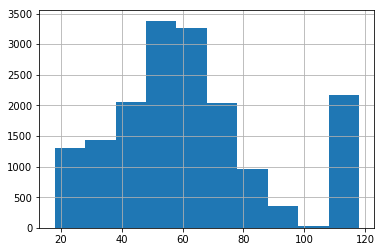

In [9]:
profile.age.hist()

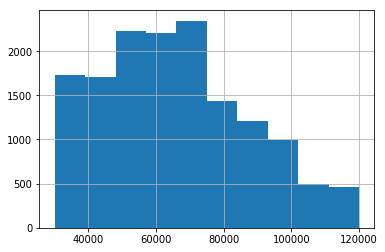

In [11]:
profile.income.hist()

#### Cleaning the Profile Data
We need to clean the profile data as follows:
1. Drop all rows with missing values.
2. Encode the `age` based on decade. For example, 24 = 20's, 31 =30's and so on.
3. Extract the year from the `became_member_on`column.
4. Encode the `gender` with dummy varibles.
5. Normalize the `income` using min max scaler. 

In [12]:
def clean_profile(profile=profile):
    """  Returns a dataframe with the clean profile data
    INPUTS:
        - profile: the profile to be cleaned
    
    OUTPUTS:
        - profile: clean profile
    """
    # Drop all rows with missing values
    profile_new = profile.dropna()

    # Extract Age decade
    profile_new['age_category'] = profile['age'].apply( lambda x : (str(int(x /10)*10) + 's'))
    profile_new = pd.get_dummies(profile_new,columns=['age_category'])
    
    # Extract Year
    profile_new['year'] = profile_new['became_member_on'].astype(str)
    profile_new['year'] = pd.to_datetime(profile_new.year).dt.year

    profile_new = pd.get_dummies(profile_new,columns=['year'])
    
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['income']
    profile_new[numerical] = scaler.fit_transform(profile_new[numerical])
    
    # Encode Gender
    profile_new = pd.get_dummies(profile_new,columns=['gender'])
    
    # Dropping unneeded columns
    profile_new.drop(columns=['became_member_on','age'],axis=1,inplace=True)
    return profile_new


In [13]:
profile_clean_df = clean_profile(profile)
display(profile_clean_df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,id,income,age_category_100s,age_category_10s,age_category_20s,age_category_30s,age_category_40s,age_category_50s,age_category_60s,age_category_70s,...,age_category_90s,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,gender_F,gender_M,gender_O
1,0610b486422d4921ae7d2bf64640c50b,0.911111,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,0.777778,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,0.444444,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
8,389bc3fa690240e798340f5a15918d5c,0.255556,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
12,2eeac8d8feae4a8cad5a6af0499a211d,0.233333,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
13,aa4862eba776480b8bb9c68455b8c2e1,0.300000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
14,e12aeaf2d47d42479ea1c4ac3d8286c6,0.177778,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
15,31dda685af34476cad5bc968bdb01c53,0.455556,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
16,62cf5e10845442329191fc246e7bcea3,0.244444,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
18,6445de3b47274c759400cd68131d91b4,0.133333,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


## III.Exploring and Analyzing the Transcript Data

In [14]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
transcript.isnull().sum().sum()

0

It is good that there are **no missing values** in our transcript data.

#### Explaining the Transcript Data

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

#### Extracting Offers From the Transcript Data
We need to extrac the offers from the transcript data as follows:
1. Split the `value` column into two cloumns `offer_id` which holds the offer id, and `reward` which will hold the reward value if the offer type is offer completed.
2. Drop all informational offers 

In [19]:
def extract_offers_from_transcript(transcript=transcript):
    """  Returns a dataframe with all the offer events in the transcript dataframe
    
    INPUT:
       - transcript: The transcript dataframe

       
    OUTPUT:
       - a dataframe that includes all offer events
    """
    offers = transcript[transcript['event'] != 'transaction']
    offers['offer_id'] = ""
    offers['reward'] = ""

    for i, row in offers.iterrows():
        if len(row.value) > 1:
            offers.at[i,'offer_id'] = list(row.value.items())[0][1]  
            offers.at[i,'reward'] = list(row.value.items())[1][1]        
        else:
            offers.at[i,'offer_id'] = list(row.value.items())[0][1]
    offers.drop(offers[offers['offer_id'].isin(informational_offer_id)].index, inplace=True)
    return offers

In [22]:
offers = extract_offers_from_transcript(transcript)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://panda

In [23]:
display(offers)

,event,person,time,value,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,
10,offer received,744d603ef08c4f33af5a61c8c7628d1c,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,


#### Creating the Offers Dataframe

Now we want to create a dataframe that shows wither a customer was influced by an offer or not.
To determine wither a customer was influced by an offer the following rules must be met:
1. The customer must recevie an offer.
2. The customer must veiw the offer with in the offer validity period.
3. The customer must complete the offer within the offer validity period.

if so then we can say that the customer was influced by the offer.

In [28]:
def create_offers_dataframe(offers=offers,profile=profile):
    """  Returns a dataframe that determines wither a customer was influced by an offer or not
    
    INPUT:
       - offers: The offers dataframe
       - profile:  the profile dataframe

       
    OUTPUT:
       - a dataframe that shows wither a customer was inflluced by an offer or not
    """
    id_count = profile.id.count() + 1
    widgets = [progressbar.Percentage(), progressbar.Bar()]
    bar = progressbar.ProgressBar(widgets=widgets, maxval= id_count).start()

    offers_df = pd.DataFrame(columns=['person', 'offer_id', 'offer_received', 'offer_viewed','offer_completed', 'influnced_by_offer'])
    bar_index = 0
    for p in profile.id:
        p_tran = offers[offers.person.isin([p])]
        off_rec = p_tran[p_tran.event.isin(['offer received'])]
        for i, row in off_rec.iterrows():
            off_dur = list(portfolio[portfolio.id == row['offer_id']].duration)[0] * 24

            off_vc = p_tran[p_tran.time.between(int(row['time']), int(row['time']) + off_dur) & p_tran.event.isin(['offer viewed', 'offer completed']) & (p_tran.offer_id == row.offer_id)]
            off_v = len(off_vc[off_vc.event == 'offer viewed'] )
            off_c = len(off_vc[off_vc.event == 'offer completed'] )
            off_i = off_v & off_c
            offers_df = offers_df.append(pd.Series([p, row['offer_id'], 1,off_v,off_c,off_i ], index=offers_df.columns ), ignore_index=True)
        bar_index+= 1
        bar.update(bar_index)
    bar.finish()
    offers_df['offer_completed_wo_view'] = ((offers_df['offer_viewed'] == 0) & (offers_df['offer_completed'] > 0)).astype(int)
    return offers_df



In [29]:
offers_file_path = "offers_2_csv"
if os.path.exists(offers_file_path):
    offers_df = pd.read_csv(offers_file_path)
else:
    with active_session():
        offers_df = create_offers_dataframe()
    offers_df.to_csv(offers_file_path)
    
display(offers_df)

,Unnamed: 0,person,offer_id,offer_received,offer_viewed,offer_completed,influnced_by_offer,offer_completed_wo_view
0,0,68be06ca386d4c31939f3a4f0e3dd783,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,0
1,1,68be06ca386d4c31939f3a4f0e3dd783,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0
2,2,68be06ca386d4c31939f3a4f0e3dd783,fafdcd668e3743c1bb461111dcafc2a4,1,2,1,0,0
3,3,68be06ca386d4c31939f3a4f0e3dd783,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0
4,4,68be06ca386d4c31939f3a4f0e3dd783,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,0,0
5,5,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,0,1
6,6,38fe809add3b4fcf9315a9694bb96ff5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,0,0
7,7,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,0
8,8,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,1,0
9,9,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,0


#### Merging the offer data and the profile data

Below we want to merge the offer data with the profile data to create the final dataframe that will be used by the supervised training algorithms.

In [30]:
def merge_profile_offer(offers_df=offers_df,portfolio_clean_df=portfolio_clean_df,profile_clean_df=profile_clean_df):
    """ Merges three dataframes to create the final dataframe that will be used to create training and testing datasets
    
    INPUT:
       - offers_df: The offers dataframe
       - portfolio_clean_df: the clean protfolio dataframe
       - profile_clean_df:  the clean profile dataframe

       
    OUTPUT:
       - a data frame that combines all of the data needed to train the learners
    """
    offer_profile_df = pd.DataFrame(columns=['id', 'offer_id', 'influnced_by_offer'])
    offer_profile_df['id'] = offers_df['person']
    offer_profile_df['offer_id'] = offers_df['offer_id']
    offer_profile_df['influnced_by_offer'] = offers_df['influnced_by_offer'].astype(bool)
    offer_profile_df = offer_profile_df.merge(portfolio_clean_df, on='offer_id')
    offer_profile_df = offer_profile_df.merge(profile_clean_df, on='id')
    return offer_profile_df

In [34]:
offer_profile_df = merge_profile_offer()
offer_profile_df.shape

(53201, 32)

#### Extracting the labels and dropping ids
Below we will extract the label of our data (influnced by offer). Then we will drop the ids from the training data

In [35]:
influnced_by_offer = offer_profile_df['influnced_by_offer']
final_offer_df = offer_profile_df.drop(['influnced_by_offer','id','offer_id'], axis=1)


In [36]:
display(final_offer_df)

,difficulty,duration,reward,offer_type_bogo,offer_type_discount,mobile,web,email,social,income,...,age_category_90s,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,gender_F,gender_M,gender_O
0,0.333333,0.4,0.000,0,1,1,1,1,0,0.444444,...,0,0,0,0,0,0,1,0,1,0
1,0.333333,1.0,0.000,0,1,1,1,1,1,0.444444,...,0,0,0,0,0,0,1,0,1,0
2,0.000000,0.4,0.375,1,0,1,1,1,0,0.444444,...,0,0,0,0,0,0,1,0,1,0
3,0.333333,0.4,0.000,0,1,1,1,1,0,0.255556,...,0,0,0,0,0,0,1,0,1,0
4,0.333333,1.0,0.000,0,1,1,1,1,1,0.255556,...,0,0,0,0,0,0,1,0,1,0
5,0.000000,0.4,0.375,1,0,1,1,1,0,0.255556,...,0,0,0,0,0,0,1,0,1,0
6,0.000000,0.4,0.375,1,0,1,1,1,0,0.255556,...,0,0,0,0,0,0,1,0,1,0
7,0.000000,0.0,0.375,1,0,1,1,1,1,0.255556,...,0,0,0,0,0,0,1,0,1,0
8,0.000000,0.0,0.375,1,0,1,1,1,1,0.255556,...,0,0,0,0,0,0,1,0,1,0
9,0.333333,0.4,0.000,0,1,1,1,1,0,0.177778,...,0,0,1,0,0,0,0,0,1,0


### Shuffle and Split Data
Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [37]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_offer_df,
                                                    influnced_by_offer,
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 42560 samples.
Testing set has 10641 samples.


In [38]:
# Naive Model
TP = np.sum(influnced_by_offer)
FP = influnced_by_offer.count() - TP
FN = TN = 0
Tot = len(influnced_by_offer)

# Calculate accuracy, precision and recall
accuracy = TP/Tot
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
B2 = 0.5*0.5
fscore = ((1 + B2) * (precision*recall) / ((B2*precision) + recall))

print("Accuracy score using naive model: {:.4f}".format(accuracy))
print("F-score using naive model: {:.4f}".format(fscore))



Accuracy score using naive model: 0.4849
F-score using naive model: 0.5406


In [39]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    """ Trains a learner and predicts values for the test data
    
    INPUT:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
       
    OUTPUT:
       - resutls which contains
        + prediction time
        + training accuracy 
        + test accuracy
        + training f-score
        + test f-score
    """
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Modling and Evaluating Model Performance
In this section, we will investigate two differnt supervised learners and evaluate their performance in predict the success or failure of a project. Moreover, we will evaluate the model's performance using 1% of the data, 10% of the data, 100% of the data.



### Three supervised learners
1. Decision Trees 
 + Strenghths: Minimal data preparation, and suitable for both categorical and numerical data!
 + Weaknesses: Over-complex trees do not generalise the data well, and learning an optimal decision tree is known to be NP-complete!
 + Why this Model: Descision Trees tend to perform well at binary classifiication.
 + [`Reference1`](https://scikit-learn.org/stable/modules/tree.html)
 + [`Reference2`](https%3A%2F%2Fbooksite.elsevier.com%2F9780124438804%2Fleondes_expert_vol1_ch3.pdf&usg=AOvVaw2I_dUwcITKT-i_yi8iChLC)
  
 
 
2. Random Forest (Ensemble Method)
 + Strenghths: Random Forests and Ensemble Methods generalize better that single esitmators (e.g. Decsion Trees)
 + Weaknesses: Random Forests might overfit if the data is noisy.
 + Why this Model: Random Forests is expected to overcome the overfitting limitation of decsion trees (our first model)
 + [`Reference1`](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)
 + [`Reference2`](http://blog.citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics)
 + [`Reference3`](https%3A%2F%2Fwww.ncbi.nlm.nih.gov%2Fpmc%2Farticles%2FPMC4062420%2F&usg=AOvVaw1VQtVvD6EmyvewEpSR1TMI)
 


3. Ada Boost
 
   + Strenghths: Adaboost is more robust than single estimators and provides imporoved generalizability.
 + Weaknesses: Depends on the classifier as it could lead to biased boosted model.
 + Why this Model: Adaboost is the one of most popular boosting algorithms.
 + [`Reference1`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)


DecisionTreeClassifier trained on 425 samples.
DecisionTreeClassifier trained on 4256 samples.
DecisionTreeClassifier trained on 42560 samples.
RandomForestClassifier trained on 425 samples.
RandomForestClassifier trained on 4256 samples.
RandomForestClassifier trained on 42560 samples.
AdaBoostClassifier trained on 425 samples.
AdaBoostClassifier trained on 4256 samples.
AdaBoostClassifier trained on 42560 samples.


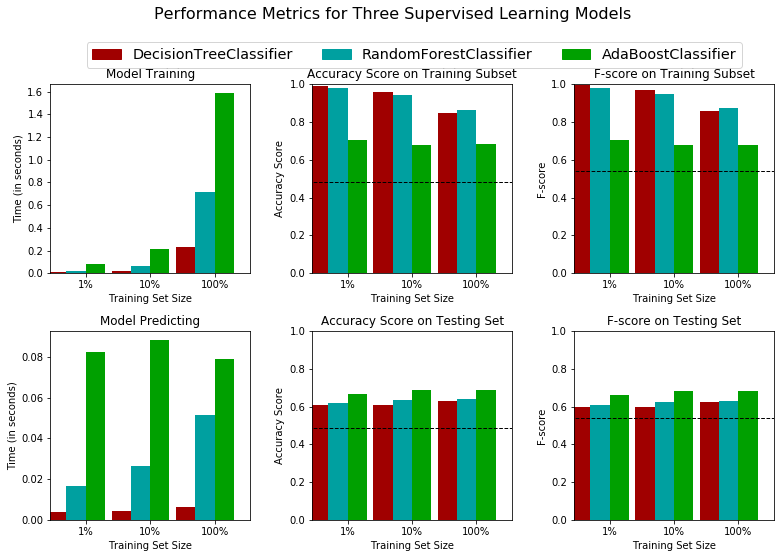

In [40]:
# Import the  supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


# Initialize the models
clf_A = DecisionTreeClassifier(random_state = 1)
clf_B = RandomForestClassifier(random_state = 1)
clf_C = AdaBoostClassifier(random_state = 1)

# Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_100 = len(y_train)
samples_10 = int(len(y_train)*0.1)
samples_1 = int(len(y_train)*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

#### Discussion of the Resutls

From the visulaizations above it looks like Adaboost has higher accuracy (68.84%) and f-score(68.25%) resutls on testing sets. However, Adaboost did not do well on the training set which indcidates underfitting. Therefore, I choose the Random Forest classifier for further tuning. Random Forest has an accuracy of (63.82%) and an f-score of (63.10%) on the testing set

In addition, from the visualization it seems that using a subset of the data leads to very high accuracy and f-score during training which indicates overfitting. Therefore, I chose to use the full training set when optimizing the Random Forest classifier.

#### Fine-tuning the Hyper-parameters of the Random Forest
Grid search will be used to fine-tune the random forest classifier.
The hyper-paramters that will be changed are:
1. `n_estimators`
2. `min_samples_leaf`

In [44]:
# Import 'GridSearchCV', 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = RandomForestClassifier(random_state = 1)


parameters = { 'n_estimators': [300,450],
               'min_samples_leaf':[1, 2, 4]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5,average='micro')

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer )

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Naive model\n------")
print("Accuracy score using naive model: {:.4f}".format(accuracy))
print("F-score using naive model: {:.4f}".format(fscore))
print("\nUnoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Naive model
------
Accuracy score using naive model: 0.4849
F-score using naive model: 0.5406

Unoptimized model
------
Accuracy score on testing data: 0.6382
F-score on testing data: 0.6310

Optimized Model
------
Final accuracy score on the testing data: 0.6911
Final F-score on the testing data: 0.6867


#### Best model parameters
below we will print the best model parameters

In [47]:
print(best_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


#### Visualizing the top features
Below we will visualize the top features that are contirbuting in the our model's prediction.

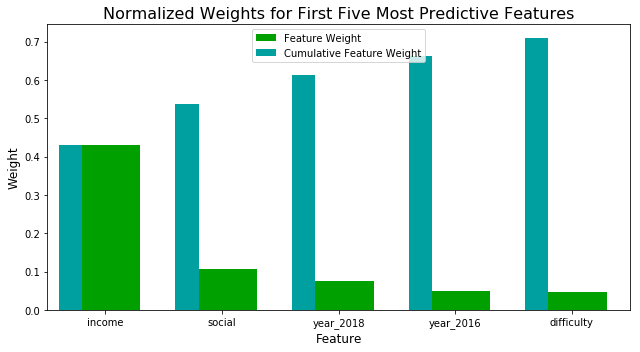

In [48]:
# Import a supervised learning model that has 'feature_importances_'

importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

#### Explaining the Top Five Features
The top five features are:
1. income: customer's income
2. social: offer was sent through social channels
3. year_2018: the customer became member in 2018
4. year_2016: the customer became member in 2016
5. diffculty: minimum required spend to complete an offer.

## Conclusion

In this project I have built a model that predicts wither a customer will be influenced by an offer or not. This project followed four main steps. First, cleaning the data and performing the necessary preprocessing transformations. Second, by understanding the data we have created a methodology to assess wither or not a customer was influenced by an offer. Next, we have compared the performance of three supervised learners to the naive predictor. The three supervised learners are decision trees, random forest, and Adaboost. Finally,  Random forest was chosen and its hyper-parameters were refined using grid search.


 Furthermore, by using the "Feature importance" property of the random forest classifier we have measured the feature's contribution in that model. Our final random forest classifier suggest that the most important five features are

 1. customer's income
 2. offer was sent through social channels
 3. The customer created an app account in 2018
 4. The customer created an app account in 2016
 5. The minimum required spend to complete an offer.

### References

* [indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)
* [drop na](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)
* [substring columns](https://stackoverflow.com/questions/663171/how-to-substring-a-string-in-python)
* [slice notion](https://stackoverflow.com/questions/509211/understanding-slice-notation)
* [get dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)
* [series str slice](https://www.geeksforgeeks.org/python-pandas-series-str-slice/)
* [extracting year](https://stackoverflow.com/questions/32725271/extract-years-from-column-of-date-strings-in-a-pandas-column)
* [group by](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
* [iterating over rows](https://cmdlinetips.com/2018/12/how-to-loop-through-pandas-rows-or-how-to-iterate-over-pandas-rows/)
* [progress bar](https://pypi.org/project/progressbar2/)